# How to: assign TF Motifs to ChIP-seq peaks

This tutorial demonstrates one way to assign CTCF motifs to CTCF ChIP-seq peaks using bioframe.


In [1]:
import bioframe
import os
import subprocess
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [2]:
base_dir = '/tmp/bioframe_tutorial_data_v2/'
assembly = 'GRCh38'

## Load CTCF ChIP-seq peaks for HFF from ENCODE

This approach makes use of the `narrowPeak` schema for bioframe.read_table . 

In [21]:
ctcf_peaks = bioframe.read_table("https://www.encodeproject.org/files/ENCFF401MQL/@@download/ENCFF401MQL.bed.gz", schema='narrowPeak')
ctcf_peaks[0:5]

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit
0,chr19,48309541,48309911,.,1000,.,5.04924,-1.0,0.00438,185
1,chr4,130563716,130564086,.,993,.,5.05052,-1.0,0.00432,185
2,chr1,200622507,200622877,.,591,.,5.05489,-1.0,0.00400,185
3,chr5,112848447,112848817,.,869,.,5.05841,-1.0,0.00441,185
4,chr1,145960616,145960986,.,575,.,5.05955,-1.0,0.00439,185


## Get CTCF motifs from JASPAR

In [22]:
### CTCF motif: http://jaspar.genereg.net/matrix/MA0139.1/
jaspar_url = 'http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2018/hg38/tsv/'
jaspar_motif_file = 'MA0139.1.tsv.gz'
ctcf_motifs = bioframe.read_table(jaspar_url+jaspar_motif_file,schema='jaspar',skiprows=1)    
ctcf_motifs[0:4]

,chrom,start,end,name,score,pval,strand
0,chrM,1259,1277,CTCF,825,449,-
1,chrM,9965,9983,CTCF,802,400,-
2,chr10,11428,11446,CTCF,808,455,-
3,chr10,11454,11472,CTCF,800,428,-


## Overlap peaks & motifs

In [25]:
df_peaks_motifs = bioframe.overlap(ctcf_peaks,ctcf_motifs, suffixes=('_1','_2'))

There are often multiple motifs overlapping one ChIP-seq peak:

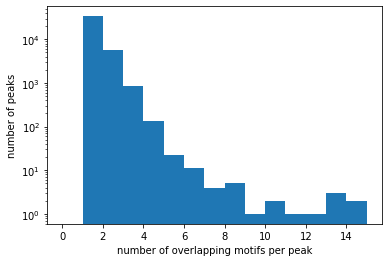

In [26]:
motifs_per_peak = df_peaks_motifs.groupby(["chrom_1", "start_1","end_1"]).size().values
plt.hist(motifs_per_peak,np.arange(0,np.max(motifs_per_peak)))
plt.xlabel('number of overlapping motifs per peak')
plt.ylabel('number of peaks')
plt.semilogy();

### assign the strongest motif to each peak

In [41]:
# since idxmax does not currently take NA, fill with -1
df_peaks_motifs['pval_2'] = df_peaks_motifs['pval_2'].fillna(-1) 
idxmax_peaks_motifs = df_peaks_motifs.groupby(["chrom_1", "start_1","end_1"])["pval_2"].idxmax().values
df_peaks_maxmotif = df_peaks_motifs.loc[idxmax_peaks_motifs]
df_peaks_maxmotif['pval_2'].replace(-1,np.nan,inplace=True)

stronger peaks tend to have stronger motifs:

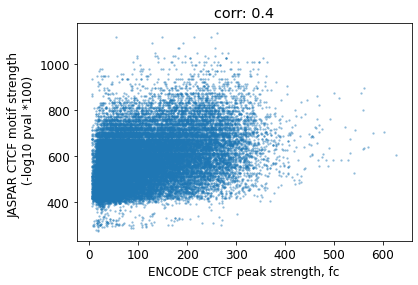

In [43]:
plt.rcParams['font.size']=12
df_peaks_maxmotif['fc_1']  = df_peaks_maxmotif['fc_1'].values.astype('float')
plt.scatter(df_peaks_maxmotif['fc_1'].values, 
            df_peaks_maxmotif['pval_2'].values, 5, alpha=0.5,lw=0)
plt.xlabel('ENCODE CTCF peak strength, fc')
plt.ylabel('JASPAR CTCF motif strength \n (-log10 pval *100)')
plt.title('corr: '+str(np.round(df_peaks_maxmotif['fc_1'].corr(df_peaks_maxmotif['pval_2']),2)));

We can also ask the reverse question: how many motifs overlap a ChIP-seq peak?

In [47]:
df_motifs_peaks = bioframe.overlap(ctcf_motifs,ctcf_peaks,how='left', suffixes=('_1','_2'))

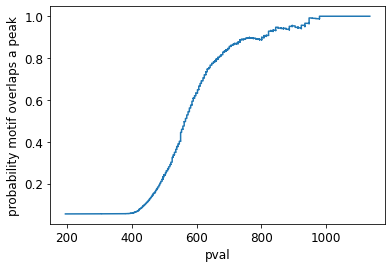

In [49]:
m = df_motifs_peaks.sort_values('pval_1')
plt.plot( m['pval_1'].values[::-1] ,
    np.cumsum(pd.isnull(m['chrom_2'].values[::-1])==0)/np.arange(1,len(m)+1))
plt.xlabel('pval')
plt.ylabel('probability motif overlaps a peak');


### filter peaks overlapping blacklisted regions

do any of our peaks overlap blacklisted genomic regions?

In [51]:
blacklist = bioframe.read_table('https://www.encodeproject.org/files/ENCFF356LFX/@@download/ENCFF356LFX.bed.gz',
                                schema='bed3')
blacklist[0:3]

,chrom,start,end
0,chr1,628903,635104
1,chr1,5850087,5850571
2,chr1,8909610,8910014


there appears to be a small spike in the number of peaks close to blacklist regions

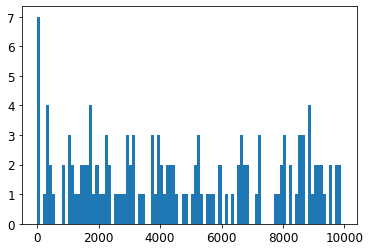

In [62]:
import matplotlib.pyplot as plt
closest_to_blacklist = bioframe.closest(ctcf_peaks,blacklist)
plt.hist(closest_to_blacklist['distance'].astype('Float64').astype('float'),np.arange(0,1e4,100));

to be safe, let's remove anything +/- 1kb from a blacklisted region

In [63]:
# first let's select the columns we want for our final dataframe of peaks with motifs
df_peaks_maxmotif = df_peaks_maxmotif[
                            ['chrom_1','start_1','end_1','fc_1',
                             'chrom_2','start_2','end_2','pval_2','strand_2']]
#  then rename columns for convenience when subtracting
for i in df_peaks_maxmotif.keys():
    if '_1' in i: df_peaks_maxmotif.rename(columns={i:i.split('_')[0]},inplace=True)

# now subtract, expanding the blacklist by 1kb        
df_peaks_maxmotif_clean = bioframe.subtract(df_peaks_maxmotif,bioframe.expand(blacklist,1000))

there it is! we now have a dataframe containing positions of CTCF ChIP peaks, 
including the strongest motif underlying that peak, and after conservative
filtering for proximity to blacklisted regions

In [64]:
df_peaks_maxmotif_clean.iloc[0:3]

,chrom,start,end,fc,chrom_2,start_2,end_2,pval_2,strand_2
0,chr19,48309541,48309911,5.04924,None,<NA>,<NA>,NaN,None
1,chr4,130563716,130564086,5.05052,None,<NA>,<NA>,NaN,None
2,chr1,200622507,200622877,5.05489,None,<NA>,<NA>,NaN,None
